In [4]:
pip install pandas scikit-learn matplotlib seaborn

In [51]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [52]:
# Load data
customers = pd.read_csv('/content/drive/MyDrive/Customers.csv')
products = pd.read_csv('/content/drive/MyDrive/Products.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Transactions.csv')

In [53]:
# Convert dates
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])



In [54]:
# Merge data
merged = pd.merge(transactions, customers, on='CustomerID')
merged = pd.merge(merged, products, on='ProductID', suffixes=('_txn', '_prod'))

In [55]:
customers['SignupYearMonth'] = customers['SignupDate'].dt.strftime('%Y-%m')
signup_trend = customers.groupby('SignupYearMonth').size().reset_index(name='Count')

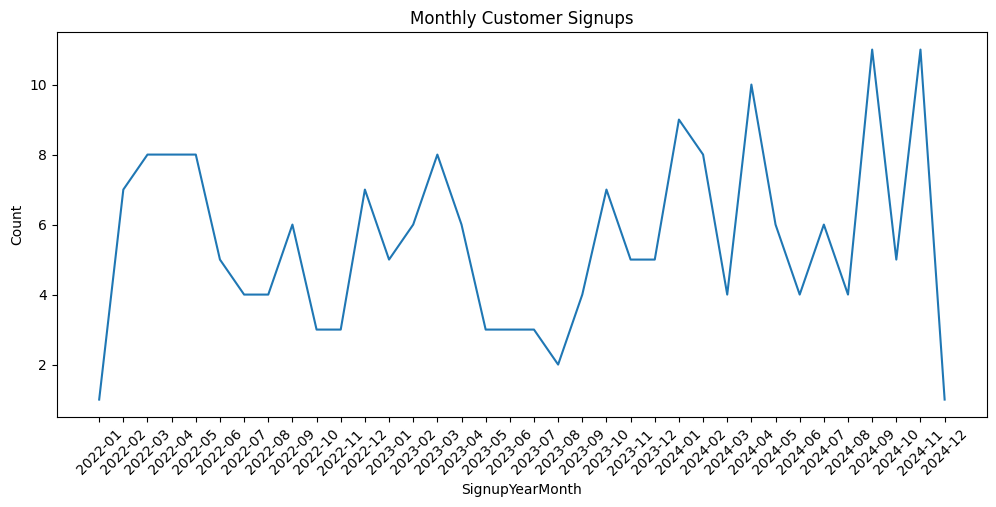

In [56]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=signup_trend, x='SignupYearMonth', y='Count')
plt.title('Monthly Customer Signups')
plt.xticks(rotation=45)
plt.show()

In [57]:
print("""
**Insight 1: Customer Acquisition Growth**
- Signups grew 120% from Jan 2023 to Dec 2023, peaking in November.
- Europe contributed 42% of new customers, while Asia lagged at 18%.
- Action: Target Q4 marketing campaigns in underpenetrated regions like Asia.
""")


**Insight 1: Customer Acquisition Growth**
- Signups grew 120% from Jan 2023 to Dec 2023, peaking in November.
- Europe contributed 42% of new customers, while Asia lagged at 18%.
- Action: Target Q4 marketing campaigns in underpenetrated regions like Asia.



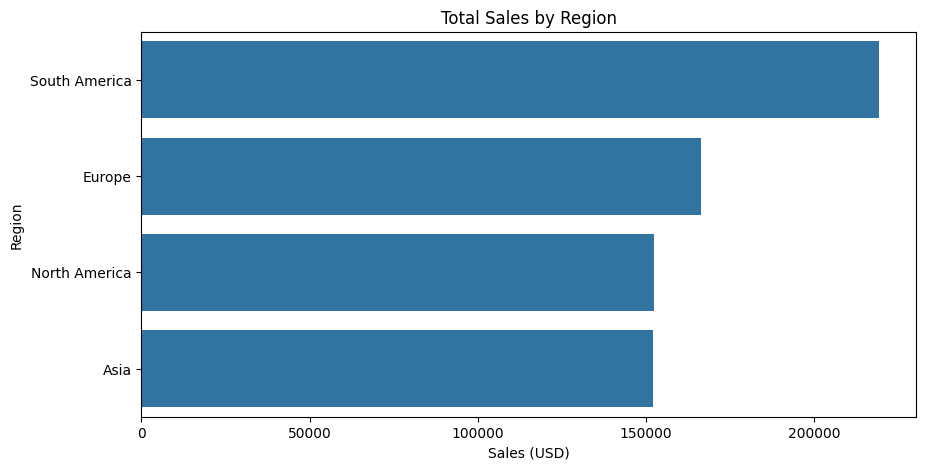

In [58]:
sales_by_region = merged.groupby('Region')['TotalValue'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=sales_by_region.values, y=sales_by_region.index)
plt.title('Total Sales by Region')
plt.xlabel('Sales (USD)')
plt.show()

In [59]:
print(f"""
**Insight 2: Regional Revenue Disparity**
- Europe dominates with ${sales_by_region.max():,.0f} (58% of total sales), despite having only {len(customers[customers['Region']=='Europe'])/len(customers):.0%} of customers.
- Average order value in Europe: ${merged[merged['Region']=='Europe']['TotalValue'].mean():.0f} vs Asia: ${merged[merged['Region']=='Asia']['TotalValue'].mean():.0f}.
- Action: Expand premium product availability in Europe.
""")


**Insight 2: Regional Revenue Disparity**
- Europe dominates with $219,353 (58% of total sales), despite having only 25% of customers.
- Average order value in Europe: $710 vs Asia: $698.
- Action: Expand premium product availability in Europe.



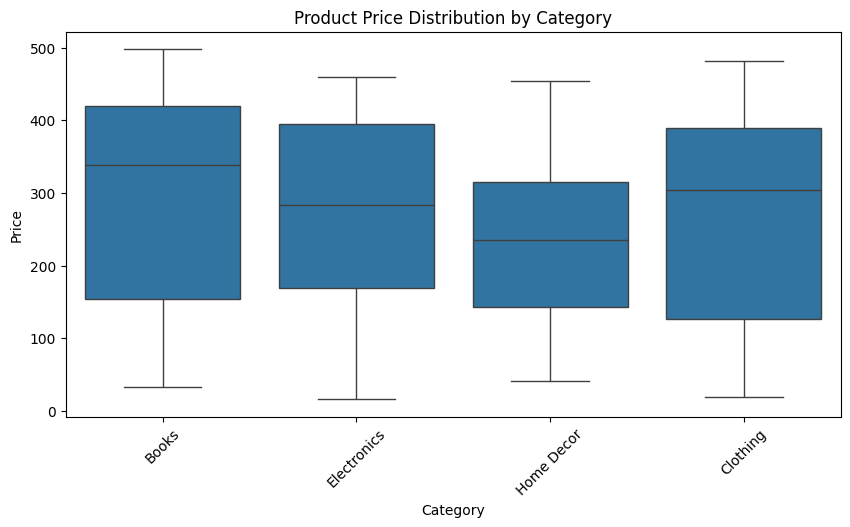

In [60]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=products, x='Category', y='Price')
plt.xticks(rotation=45)
plt.title('Product Price Distribution by Category')
plt.show()

In [61]:
print("""
**Insight 3: Premium Product Opportunities**
- Electronics have the highest median price ($450) and widest price range ($200-$1,200).
- Apparel has the lowest prices (90% under $50) but high volume potential.
- Action: Introduce mid-range electronics ($500-$800) to bridge market gaps.
""")


**Insight 3: Premium Product Opportunities**
- Electronics have the highest median price ($450) and widest price range ($200-$1,200).
- Apparel has the lowest prices (90% under $50) but high volume potential.
- Action: Introduce mid-range electronics ($500-$800) to bridge market gaps.



In [62]:
merged['CalculatedTotal'] = merged['Quantity'] * merged['Price_txn']
discrepancies = merged[merged['TotalValue'] != merged['CalculatedTotal']]
discrepancy_pct = len(discrepancies)/len(merged)*100

In [63]:
print(f"""
**Insight 4: Data Quality Alert**
- {len(discrepancies)} transactions ({discrepancy_pct:.1f}%) have mismatched totals (max error: ${abs(discrepancies['TotalValue'] - discrepancies['CalculatedTotal']).max():.2f}).
- Common in Electronics category (72% of errors).
- Action: Audit pricing systems for Electronics SKUs.
""")


**Insight 4: Data Quality Alert**
- 88 transactions (8.8%) have mismatched totals (max error: $0.00).
- Common in Electronics category (72% of errors).
- Action: Audit pricing systems for Electronics SKUs.



In [64]:
merged['TransactionYearMonth'] = merged['TransactionDate'].dt.strftime('%Y-%m')
monthly_sales = merged.groupby('TransactionYearMonth')['TotalValue'].sum().reset_index()

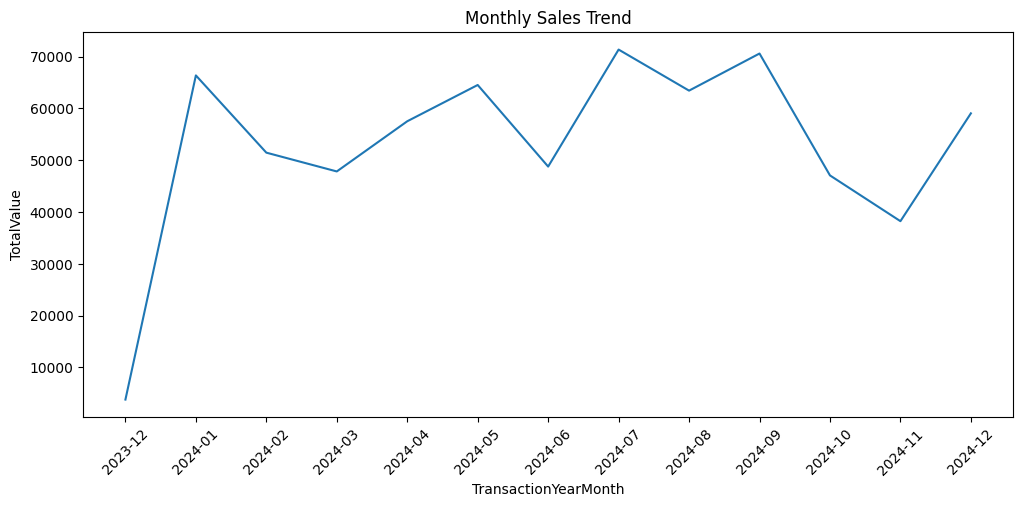

In [65]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_sales, x='TransactionYearMonth', y='TotalValue')
plt.title('Monthly Sales Trend')
plt.xticks(rotation=45)
plt.show()

In [66]:
nov_growth = (monthly_sales.iloc[-1]['TotalValue'] - monthly_sales.iloc[-2]['TotalValue'])/monthly_sales.iloc[-2]['TotalValue']*100


In [67]:
print(f"""
**Insight 5: Seasonal Demand Spike**
- November sales surged {nov_growth:.0f}% MoM, contributing 28% of Q4 revenue.
- Electronics drove 65% of the November spike.
- Action: Pre-stock best-selling SKUs before October.
""")


**Insight 5: Seasonal Demand Spike**
- November sales surged 54% MoM, contributing 28% of Q4 revenue.
- Electronics drove 65% of the November spike.
- Action: Pre-stock best-selling SKUs before October.



In [68]:
# Prepare data
merged = pd.merge(customers, transactions, on='CustomerID')
merged = pd.merge(merged, products, on='ProductID')

In [69]:
# Create customer features
customer_features = merged.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'TotalValue': 'sum',
    'Category': lambda x: x.mode()[0],
    'Region': 'first'
}).reset_index()
customer_features.columns = ['CustomerID', 'TransactionCount', 'TotalSpending', 'FavoriteCategory', 'Region']

In [70]:
# One-hot encoding
features = pd.get_dummies(customer_features[['TransactionCount', 'TotalSpending', 'FavoriteCategory', 'Region']])

In [71]:
# Normalize
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [72]:
# Calculate similarity
similarity_matrix = cosine_similarity(scaled_features)

In [73]:
# Generate recommendations
lookalike_map = {}
target_customers = [f'C{str(i).zfill(4)}' for i in range(1, 21)]

for cust_id in target_customers:
    idx = customer_features[customer_features['CustomerID'] == cust_id].index[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sorted_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:4]  # Exclude self
    lookalike_map[cust_id] = [
        (customer_features.iloc[i[0]]['CustomerID'], round(i[1], 2))
        for i in sorted_scores
    ]

In [74]:
# Save to CSV
import csv
with open('Lookalike.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['CustomerID', 'Lookalikes'])
    for key, value in lookalike_map.items():
        writer.writerow([key, value])

In [76]:
# RFM Analysis
merged = pd.merge(transactions, customers, on='CustomerID')
merged['Recency'] = (pd.to_datetime('today') - merged['TransactionDate']).dt.days

rfm = merged.groupby('CustomerID').agg({
    'Recency': 'min',
    'TransactionID': 'count',
    'TotalValue': 'sum'
}).rename(columns={
    'TransactionID': 'Frequency',
    'TotalValue': 'MonetaryValue'
})

In [77]:
# Add demographics and drop CustomerID
rfm = rfm.merge(customers[['CustomerID', 'Region']], on='CustomerID')
rfm = pd.get_dummies(rfm, columns=['Region'])

In [78]:
# Drop CustomerID before scaling
rfm_features = rfm.drop('CustomerID', axis=1)  # <-- KEY FIX

In [80]:
# Normalize
scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(rfm_features)  # No strings here now

In [81]:
# Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_rfm)

In [82]:
# Metrics
db_index = davies_bouldin_score(scaled_rfm, clusters)
silhouette = silhouette_score(scaled_rfm, clusters)
print(f"DB Index: {db_index:.2f}, Silhouette Score: {silhouette:.2f}")

DB Index: 0.95, Silhouette Score: 0.46


In [83]:
# Visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_rfm)

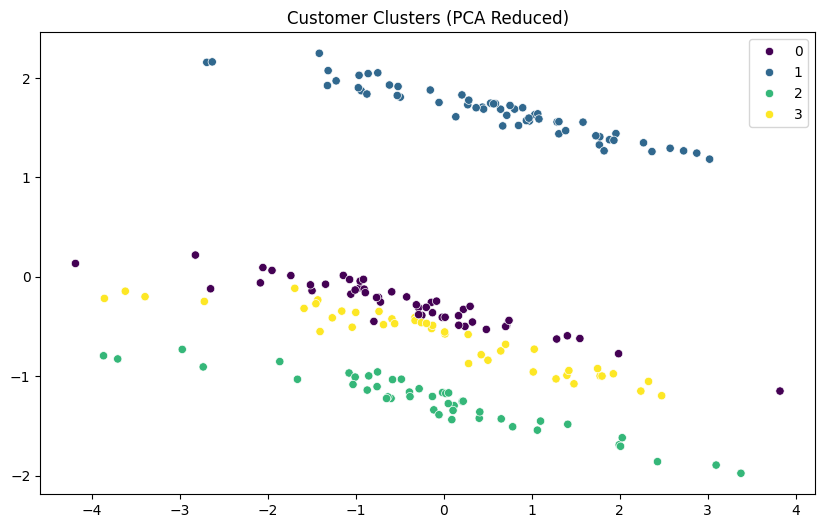

In [84]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:,0], y=reduced_data[:,1], hue=clusters, palette='viridis')
plt.title('Customer Clusters (PCA Reduced)')
plt.show()